In [1]:
import optax
import equinox as eqx
from jax import numpy as jnp, random as jr, vmap, nn

import numpy as np
from matplotlib import pyplot as plt


from pets.train import train
from pets.model import Ensemble
from pets.cartpole import CartPoleEnv
from pets.dataset import Dataset, Normalizer

In [2]:
def sample_episodes(env, dataset, num_episodes):
    for _ in range(num_episodes):
        (state, _), done = env.reset(), False
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, truncated, info = env.step(action)
            dataset.add(state, action, reward, next_state)
            state = next_state
    return dataset


def sample_trajectory(env):
    (state, _), done, trajectory = env.reset(), False, []
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, truncated, info = env.step(action)
        trajectory.append((state, action, reward, next_state))
        state = next_state
    states, actions, rewards, next_states = zip(*trajectory)
    return jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(next_states)

In [3]:
key = jr.PRNGKey(0)

num_random_episodes, num_train_epochs = 1000, 20
batch_dim, hidden_dim, ensemble_dim = 32, 200, 5

env = CartPoleEnv()
state_dim, action_dim = env.observation_space.shape[0], env.action_space.shape[0]

normalizer = Normalizer(state_dim + action_dim)
dataset = Dataset(state_dim, action_dim, ensemble_dim)
dataset = sample_episodes(env, dataset, num_random_episodes)

model = Ensemble(state_dim + action_dim, state_dim, hidden_dim, ensemble_dim, key=key)

optim = optax.adamw(learning_rate=1e-4, weight_decay=1e-5, eps=1e-8)
optim_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

model, optim_state, losses = train(model, optim, optim_state, dataset, normalizer, batch_dim, num_train_epochs)

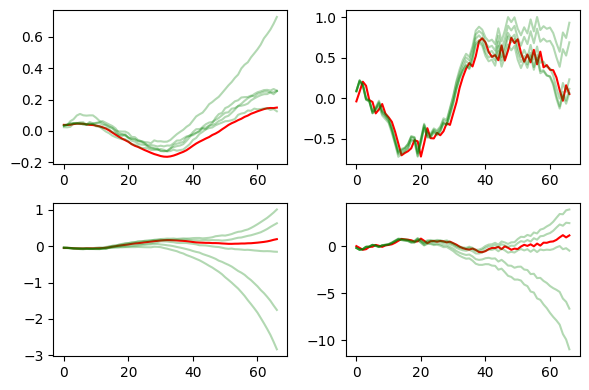

In [4]:
_tile = lambda x: jnp.tile(x[None, ...], (ensemble_dim, 1))

def forward(model, normalizer, state, action, key):
    inputs = jnp.concatenate([state, _tile(action)], axis=-1)
    inputs = normalizer.normalize(inputs)
    delta_mean, delta_logvar = model(inputs)
    delta_std = jnp.sqrt(jnp.exp(delta_logvar))
    delta = delta_mean + delta_std * jr.normal(key, delta_mean.shape)
    return state + delta


def rollout(model, normalizer, state, actions, key):
    states = []

    state = _tile(state)
    for action in actions:
        key, subkey = jr.split(key)
        state = forward(model, normalizer, state, action, subkey)
        states.append(state)
    return jnp.array(states)


key, subkey = jr.split(key)
states, actions, rewards, next_states = sample_trajectory(env)
preds = rollout(model, normalizer, states[0], actions, subkey)


fig, axes = plt.subplots(2, 2, figsize=(6, 4))
for idx, ax in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    axes[ax].plot(states[:, idx], c="r")
    axes[ax].plot(preds[:, :, idx], c="g", alpha=0.3)
plt.tight_layout()
plt.show()